Pelin Yurdadön

In [1]:
home = "C:\\Users\\paslanpatir\\Documents\\GitHub\\fall21-yurdadonpelin"
setwd(home)

In [11]:
library(data.table)
library(tidyverse)
library(ggplot2)
library(caret)

Warning message:
"package 'caret' was built under R version 3.6.3"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




In [3]:
musk = fread("Musk1.csv")
setnames(musk, c("V1","V2"), c("BagClass","BagId"))

In [4]:
#Check NA columns:
na_count <-sapply(musk, function(y) sum(length(which(is.na(y)))))
t(na_count)  
#There are not any NA columns

head(musk)
nrow(musk)
paste0("There are ",length(unique(musk$BagId)), " molecules")
paste0("Type of molecules are shown with ",length(unique(musk$BagClass))," BagClasses")

BagClass,BagId,V3,V4,V5,V6,V7,V8,V9,V10,...,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


BagClass,BagId,V3,V4,V5,V6,V7,V8,V9,V10,...,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,42,-198,-109,-75,-117,11,23,-88,...,-238,-74,-129,-120,-38,30,48,-37,6,30
1,1,42,-191,-142,-65,-117,55,49,-170,...,-238,-302,60,-120,-39,31,48,-37,5,30
1,1,42,-191,-142,-75,-117,11,49,-161,...,-238,-73,-127,-120,-38,30,48,-37,5,31
1,1,42,-198,-110,-65,-117,55,23,-95,...,-238,-302,60,-120,-39,30,48,-37,6,30
1,2,42,-198,-102,-75,-117,10,24,-87,...,-238,-73,-127,51,128,144,43,-30,14,26
1,2,42,-191,-142,-65,-117,55,49,-170,...,-238,-300,61,51,127,143,42,-31,14,26


[1] 476

[1] "There are 92 molecules"

[1] "Type of molecules are shown with 2 BagClasses"

In [5]:
#standardize
musk_scaled <- scale(musk[,-c(1:2)],center = TRUE, scale = TRUE)
musk_scaled = cbind(musk[,c(1:2)], musk_scaled)

BagClass,BagId,variable,value,x_axis
<int>,<int>,<fct>,<int>,<chr>
1,1,V3,42,3
1,1,V3,42,3
1,1,V3,42,3
1,1,V3,42,3
1,2,V3,42,3
1,2,V3,42,3


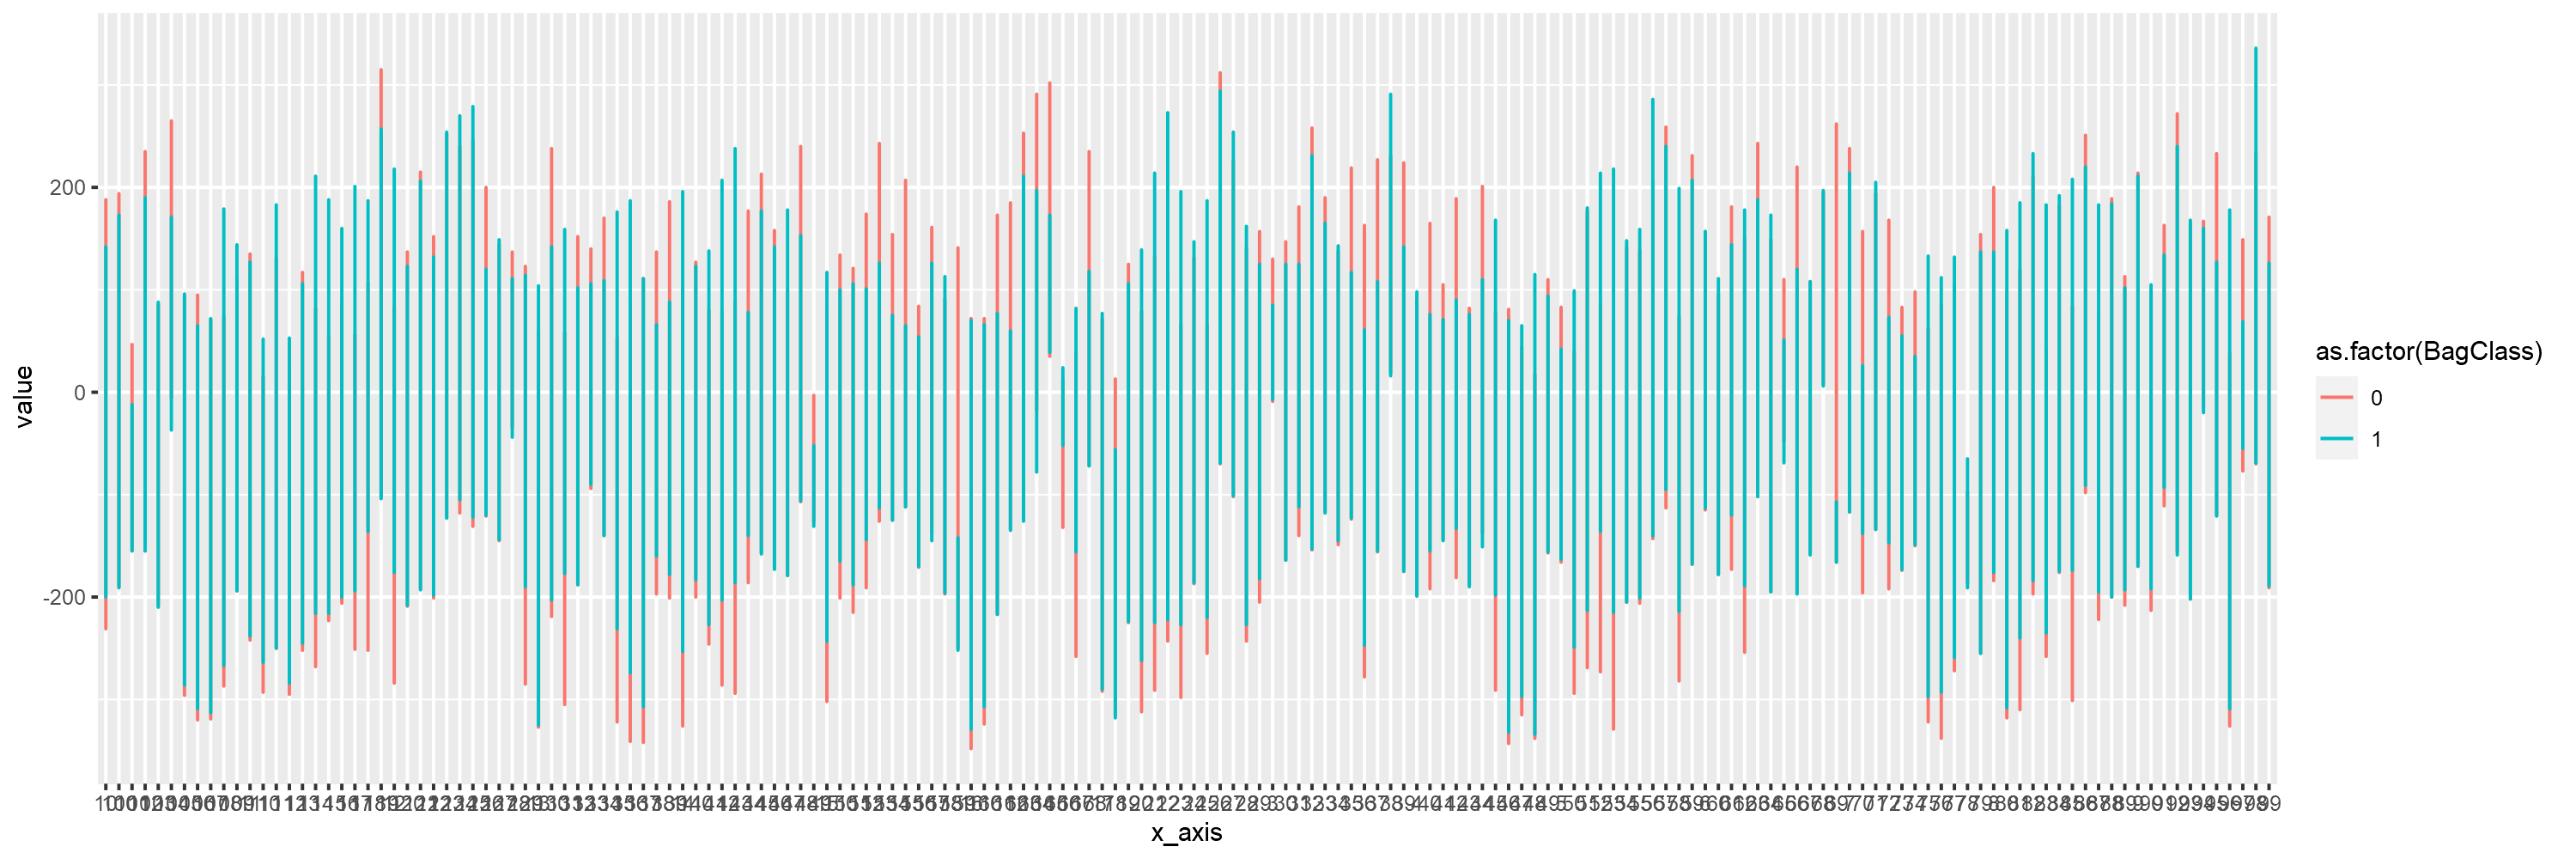

In [6]:
#melt the data
musk_molten = melt(musk, id.vars = c("BagClass","BagId"))
musk_molten$x_axis = str_remove(musk_molten$variable,"V")
head(musk_molten)

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)
ggplot(data= musk_molten, aes(x = x_axis, y = value, col = as.factor(BagClass))) + geom_line() 

# Bagging Approach 1

Standard deviations of features in a bag can be meaningful as variance holds information in general.

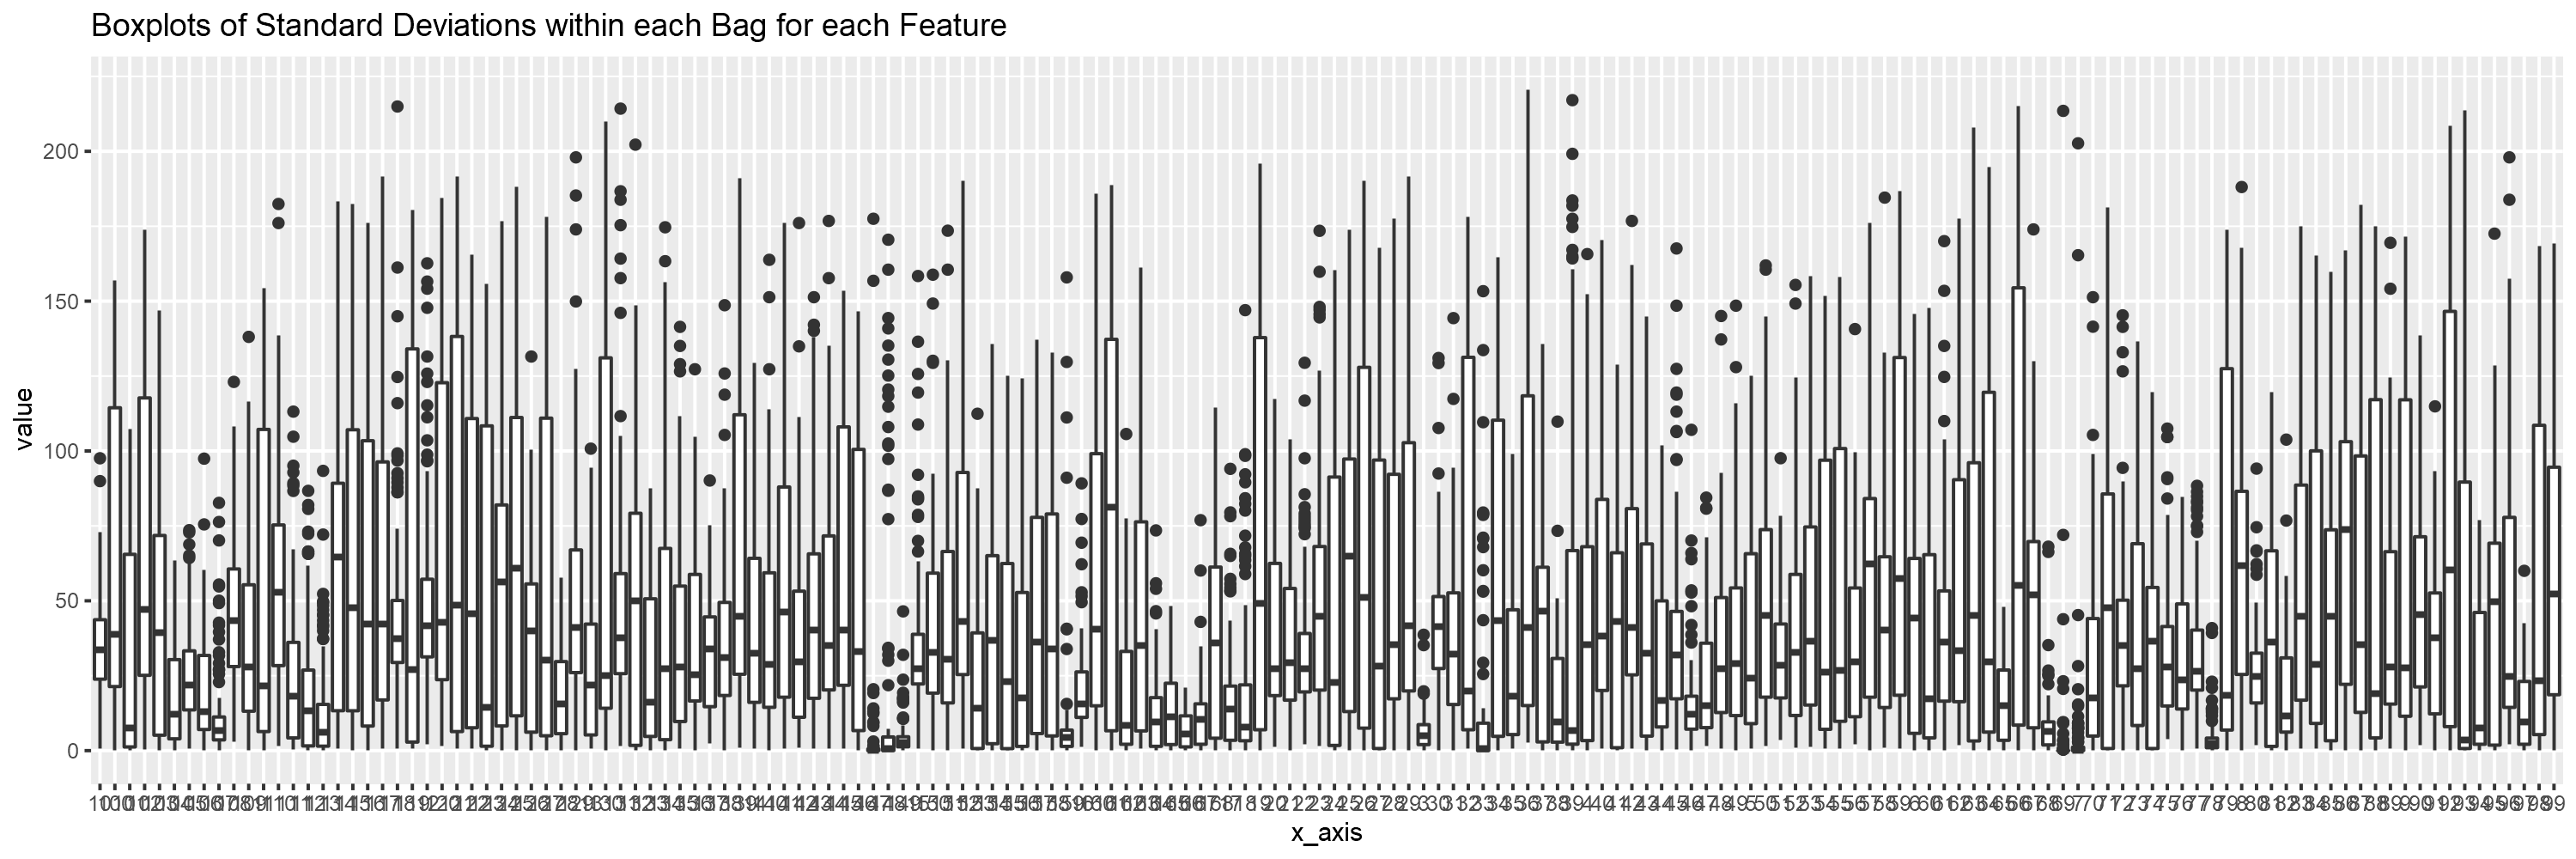

In [23]:
musk_sd= musk[,lapply(.SD,FUN = sd),.(BagClass,BagId),.SDcols = -c("BagClass","BagId")]
musk_sd = melt(musk_sd, id.vars = c("BagClass","BagId"))
musk_sd$x_axis = str_remove(musk_sd$variable,"V")

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)
ggplot(data= musk_sd, aes(x = x_axis, y = value)) + geom_boxplot() + ggtitle("Boxplots of Standard Deviations within each Bag for each Feature")

According to the boxplots above, the standard deviations(sd) within each bag seems to be quite large for most of the features as sd values can reach up to 225. Therefore, the first approach takes sd into account. 

However, the scale of each feature seems to be different as well. Therefore, we also need to normalize(sort of) sd values with mean values. 

Indeed there is such a metric called "coefficient of variance" (coefvar).

As a result, we aggregate instance level data to bag level data by considering coefficient of variance within each feature for each bag.

In [7]:
# calculation of coeff. of var.
coefvar = function(x){ 
    cv = ifelse(mean(x) != 0, sd(x) / mean(x), sd(x))
    return(cv)
}

In [8]:
# bag level data
musk1 = musk[,lapply(.SD,FUN = coefvar),.(BagClass,BagId),.SDcols = -c("BagClass","BagId")]

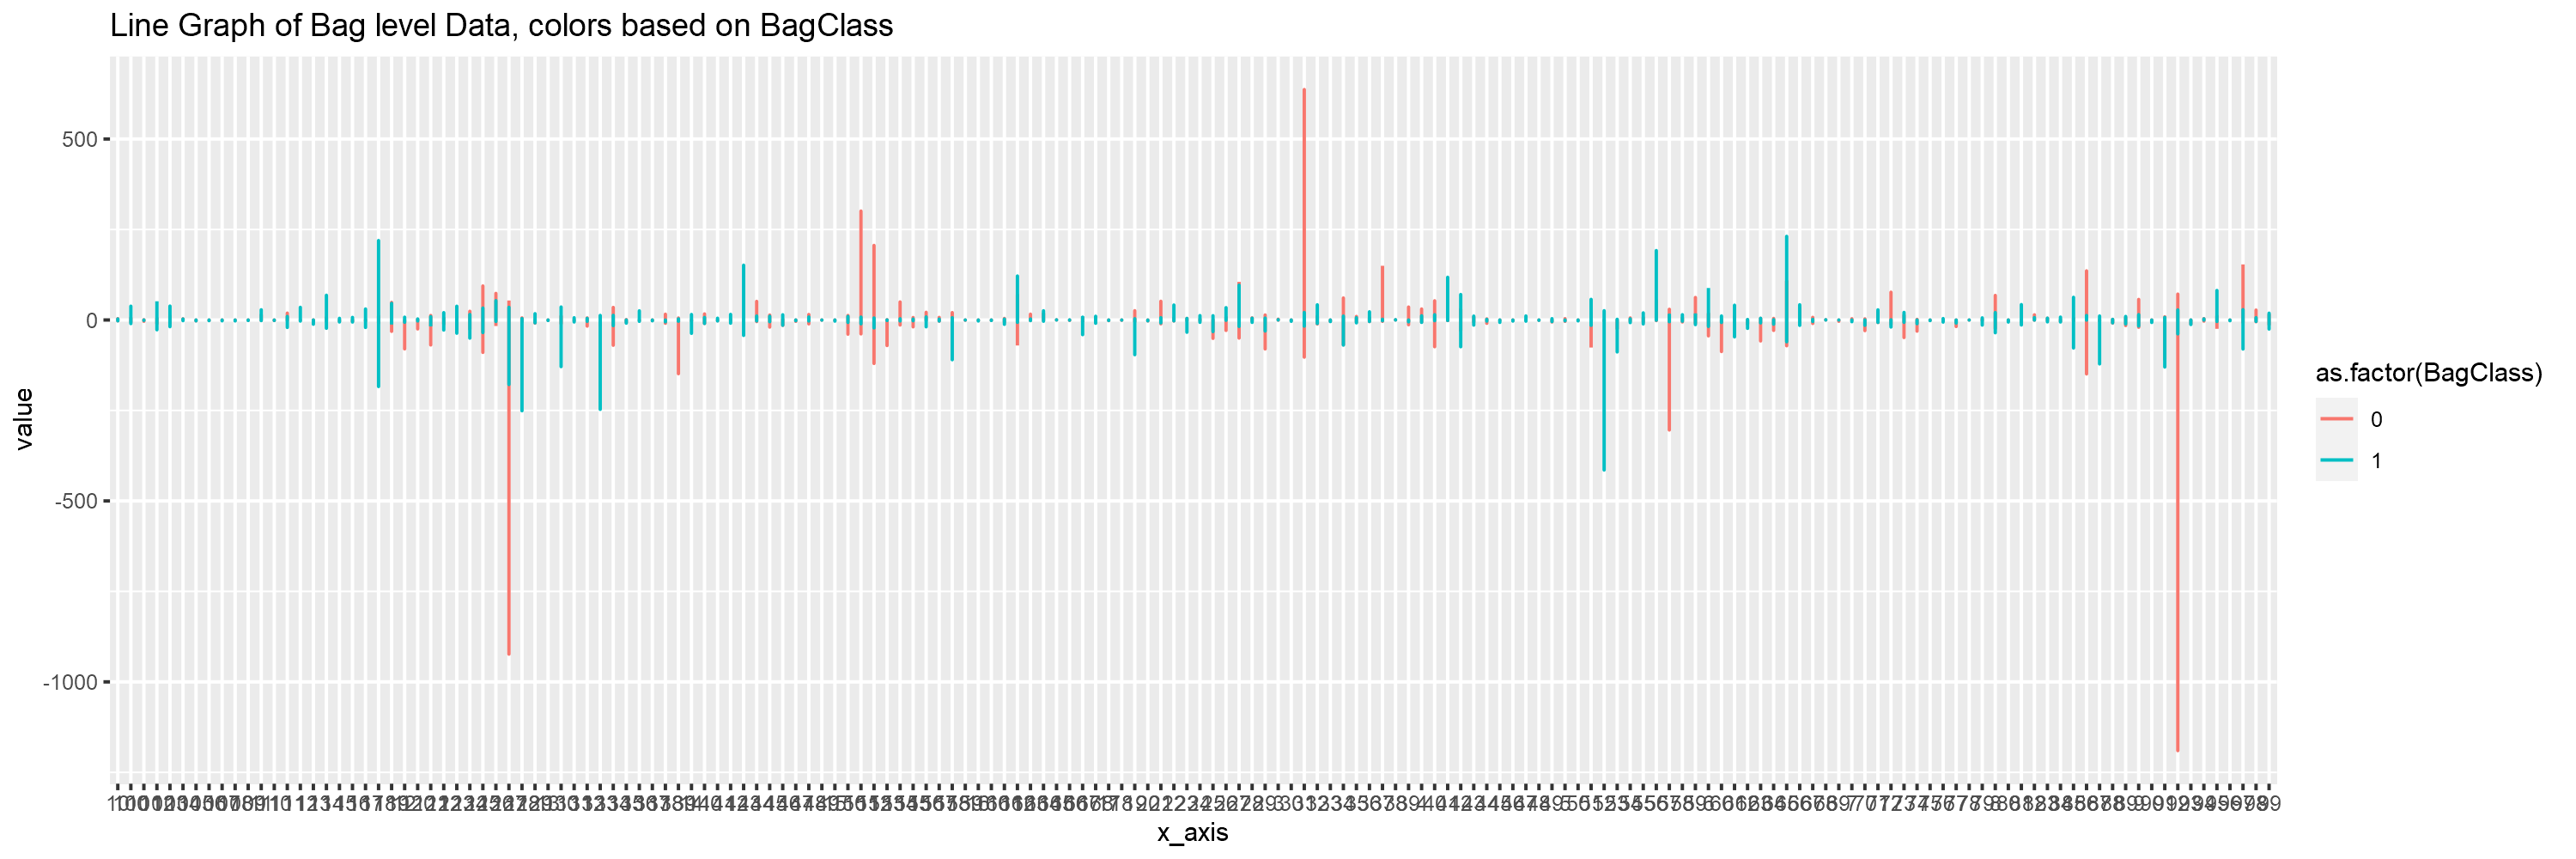

In [24]:
musk1_molten = melt(musk1, id.vars = c("BagClass","BagId"))
musk1_molten$x_axis = str_remove(musk1_molten$variable,"V")

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)
ggplot(data= musk1_molten, aes(x = x_axis, y = value, col = as.factor(BagClass))) + geom_line() + ggtitle("Line Graph of Bag level Data, colors based on BagClass")

The plot above shows that spikes of coefvar in some features can give hints for BagClass.

In [12]:
set.seed(8294728)
tr_idx <- createDataPartition(musk1$BagClass, p = 0.7, list = FALSE)
trainData = musk1[tr_idx,]
testData = musk1[-tr_idx,]

feature_cols = setdiff(colnames(musk1),c("BagClass","BagId"))
x_train = trainData[,.SD,.SDcols = feature_cols]
y_train = as.factor(trainData$BagClass)

x_test = testData[,.SD,.SDcols = feature_cols]
y_test = as.factor(testData$BagClass)

levels(y_train) <- c("nonmusk", "musk")

As this bagging approach takes no parameter, no parameter tuning for bag level aggregation step is performed.

## Model 1 : XGBoost

Here, max_depth, eta and gamma are considered in parameter tuning as these are the most effective parameters in general.
I decided nrounds = 40 by trials.

In [25]:
# create the training control object. 
trControl = trainControl(
    method = 'cv',
    number = 10,
   # summaryFunction = twoClassSummary,
    classProbs = TRUE,
    verboseIter = TRUE,
    allowParallel = TRUE)

# create the tuning grid. 
tuneGridXGB <- expand.grid(
    nrounds=c(40),
    max_depth = c(4,5,6),
    eta = c(0.05, 0.1, 0.3),
    gamma = c(0.01, 0.1, 0.2),
    colsample_bytree = c(1),
    subsample = c(1),
    min_child_weight = c(1))

start <- Sys.time()
# train the xgboost learner
xgbmod <- train(
    x = x_train,
    y = y_train,
    method = 'xgbTree',
    metric="Accuracy",
    trControl = trControl,
    tuneGrid = tuneGridXGB)

print(Sys.time() - start)

+ Fold01: eta=0.05, max_depth=4, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=4, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=4, gamma=0.10, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=4, gamma=0.10, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=4, gamma=0.20, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=4, gamma=0.20, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=5, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=5, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=5, gamma=0.10, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: 

Selecting tuning parameters
Fitting nrounds = 40, max_depth = 4, eta = 0.3, gamma = 0.01, colsample_bytree = 1, min_child_weight = 1, subsample = 1 on full training set
Time difference of 1.180167 mins


In [26]:
#best parameter setting
xgbmod$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,40,4,0.3,0.01,1,1,1


In [30]:
# make predictions
preds <- predict(xgbmod, newdata = x_test, type = "prob")

In [34]:
th = 0.5 # threshold for classification
y_pred = ifelse(preds$musk>= th, 1,0) 
table(y_pred,y_test)

accuracy_xgb = 1.00*sum(ifelse(y_test == y_pred,1,0))/length(y_pred)
print(accuracy_xgb)

      y_test
y_pred  0  1
     0 10  6
     1  3  8

[1] 0.6666667


Here, I tried different thresholds and saw that th = 0.3 provides the best accuracy.However, in the training set the numbers of musk and nonmusk bags are almost the same. Therefore, I decided to set th = 0.5 in order to avoid overfitting to the test set.

## Model 2 : Logistic Boosting

logistic boosting in caret package has only 1 parameter called nIter. Therefore, it is the only parameter tuned.

In [36]:
# create the training control object. Two-fold CV to keep the execution time under the kaggle
# limit. You can up this as your compute resources allow. 
trControl = trainControl(
    method = 'cv',
    number = 10,
   # summaryFunction = twoClassSummary,
    classProbs = TRUE,
    verboseIter = TRUE,
    allowParallel = TRUE)

# create the tuning grid. Again keeping this small to avoid exceeding kernel memory limits.
# You can expand as your compute resources allow. 
tuneGrid <- expand.grid(
    nIter = c(10,20,30,40,50,60,70,80,90,100))

start <- Sys.time()
# train the xgboost learner
logitbmod <- train(
    x = x_train,
    y = y_train,
    method = 'LogitBoost',
    metric="Accuracy",
    trControl = trControl,
    tuneGrid = tuneGrid)

print(Sys.time() - start)

+ Fold01: nIter=100 
- Fold01: nIter=100 
+ Fold02: nIter=100 
- Fold02: nIter=100 
+ Fold03: nIter=100 
- Fold03: nIter=100 
+ Fold04: nIter=100 
- Fold04: nIter=100 
+ Fold05: nIter=100 
- Fold05: nIter=100 
+ Fold06: nIter=100 
- Fold06: nIter=100 
+ Fold07: nIter=100 
- Fold07: nIter=100 
+ Fold08: nIter=100 
- Fold08: nIter=100 
+ Fold09: nIter=100 
- Fold09: nIter=100 
+ Fold10: nIter=100 
- Fold10: nIter=100 
Aggregating results
Selecting tuning parameters
Fitting nIter = 60 on full training set
Time difference of 2.464782 secs


Best nIter is found to be 60.

In [37]:
# make predictions
preds_lg<- predict(logitbmod, newdata = x_test, type = "prob")

In [38]:
th = 0.5 # threshold for classification
y_pred = ifelse(preds_lg$musk>= th, 1,0) 
table(y_pred,y_test)

accuracy_lg = 1.00*sum(ifelse(y_test == y_pred,1,0))/length(y_pred)
print(accuracy_lg)

      y_test
y_pred  0  1
     0  9  2
     1  4 12

[1] 0.7777778


## Comparison of Models

In [69]:
accuracy_xgb
accuracy_lg

[1] 0.6666667

[1] 0.7777778

Accuracies listed just above apparently shows that logistic boosting  performs better than xgboost model for this bagging approach.

# Bagging Approach 2

Here, I focused on the similarity of instances in a bag. Euclidean and Manhatatan distances are considered as a part of tuning in bag-level-aggregation step.

The instance which is the most similar to the others in the bag is chosen as the representative instance of the bag and only that instance is used in aggregation of the instance level data to the bag level.

## Model 1 : XGBoost

### With Euclidean Distance based Similarity

In [39]:
musk2 = copy(musk)
musk2[, instance_id := 1:.N,.(BagId)]

In [40]:
i = 1
while(i <= max(musk$BagId)){
    musk_focus = musk_scaled[BagId == i,.SD,.SDcols= -c("BagClass","BagId")]
    # create distance matrix:
    scaled_musk_dist = as.data.table(as.matrix(dist(musk_focus, method = "euclidean")))
    scaled_musk_dist[scaled_musk_dist == 0] = NA
    
    rep_bag = which.min(lapply(scaled_musk_dist,mean, na.rm = TRUE))
    musk2 = musk2[!(BagId == i & instance_id != rep_bag)]
    i = i + 1
}

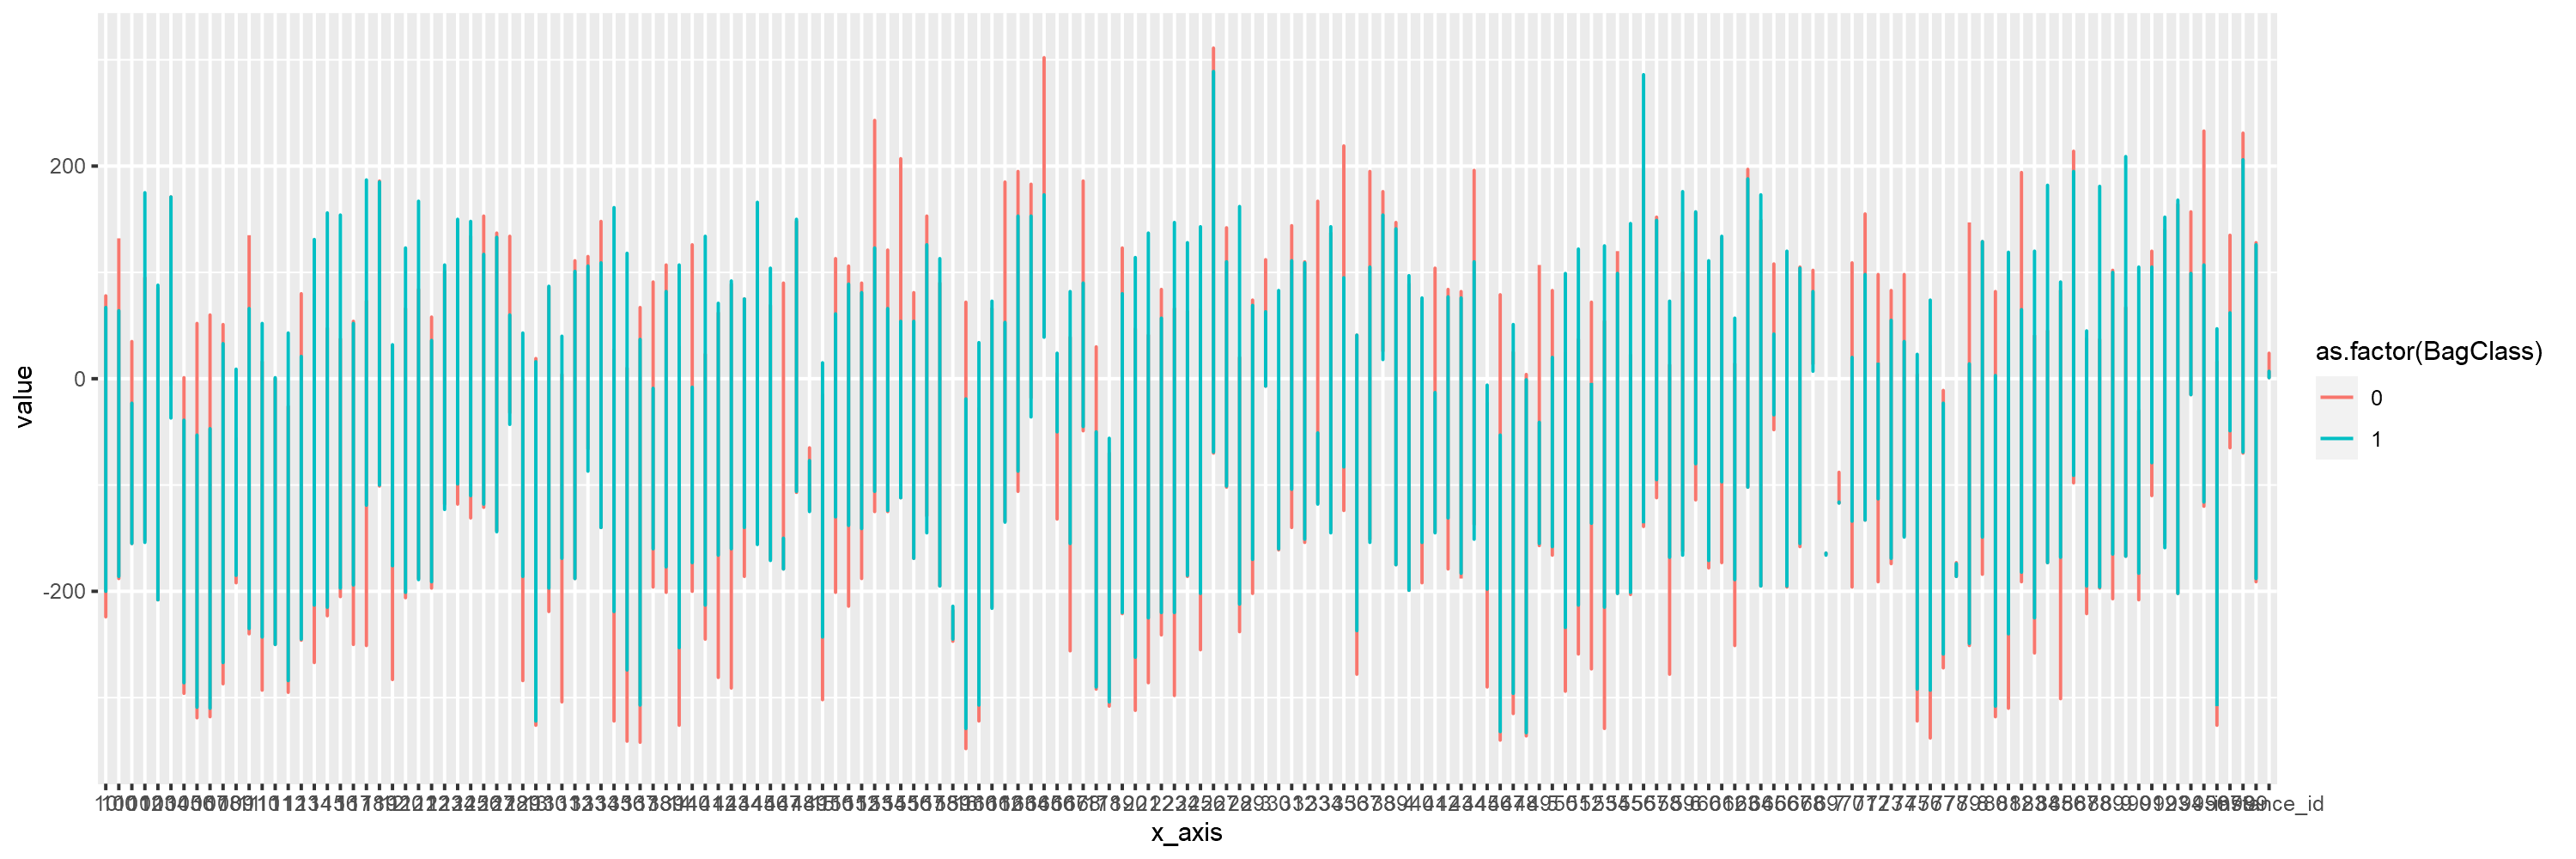

In [54]:
musk2_molten = melt(musk2, id.vars = c("BagClass","BagId"))
musk2_molten$x_axis = str_remove(musk2_molten$variable,"V")

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)
ggplot(data= musk2_molten, aes(x = x_axis, y = value, col = as.factor(BagClass))) + geom_line() #+ facet_wrap(~BagClass, nrow= 2)

The representative instances of bags seem to carry sufficient information to predict bag classes in an extent as the orange spikes are generally longer than the blue spkies in the above graph. 

In [41]:
#set.seed(8294728)
#tr_idx <- createDataPartition(musk1$BagClass, p = 0.7, list = FALSE)
trainData = musk2[tr_idx,]
testData = musk2[-tr_idx,]

feature_cols = setdiff(colnames(musk2),c("BagClass","BagId","instance_id"))
x_train = trainData[,.SD,.SDcols = feature_cols]
y_train = as.factor(trainData$BagClass)

x_test = testData[,.SD,.SDcols = feature_cols]
y_test = as.factor(testData$BagClass)

levels(y_train) <- c("nonmusk", "musk")

In [42]:
# create the training control object. Two-fold CV to keep the execution time under the kaggle
# limit. You can up this as your compute resources allow. 
trControl = trainControl(
    method = 'cv',
    number = 10,
   # summaryFunction = twoClassSummary,
    classProbs = TRUE,
    verboseIter = TRUE,
    allowParallel = TRUE)

# create the tuning grid. Again keeping this small to avoid exceeding kernel memory limits.
# You can expand as your compute resources allow. 
tuneGridXGB <- expand.grid(
    nrounds=c(40),
    max_depth = c(4,5,6),
    eta = c(0.05, 0.1, 0.3),
    gamma = c(0.01, 0.1, 0.2),
    colsample_bytree = c(1),
    subsample = c(1),
    min_child_weight = c(1))

start <- Sys.time()
# train the xgboost learner
xgbmod <- train(
    x = x_train,
    y = y_train,
    method = 'xgbTree',
    metric="Accuracy",
    trControl = trControl,
    tuneGrid = tuneGridXGB)

print(Sys.time() - start)

+ Fold01: eta=0.05, max_depth=4, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=4, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=4, gamma=0.10, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=4, gamma=0.10, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=4, gamma=0.20, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=4, gamma=0.20, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=5, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=5, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=5, gamma=0.10, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: 

Selecting tuning parameters
Fitting nrounds = 40, max_depth = 4, eta = 0.1, gamma = 0.2, colsample_bytree = 1, min_child_weight = 1, subsample = 1 on full training set
Time difference of 1.194282 mins


In [43]:
xgbmod$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,40,4,0.1,0.2,1,1,1


In [44]:
# make predictions
preds <- predict(xgbmod, newdata = x_test, type = "prob")

In [45]:
th = 0.5 # threshold for classification
y_pred = ifelse(preds$musk>= th, 1,0) 
table(y_pred,y_test)

accuracy_xgb_euc = 1.00*sum(ifelse(y_test == y_pred,1,0))/length(y_pred)
print(accuracy_xgb_euc)

      y_test
y_pred  0  1
     0 10  1
     1  3 13

[1] 0.8518519


### With Manhattan Distance Similarity

In [46]:
musk2 = copy(musk)
musk2[, instance_id := 1:.N,.(BagId)]

In [47]:
i = 1
while(i <= max(musk$BagId)){
    musk_focus = musk_scaled[BagId == i,.SD,.SDcols= -c("BagClass","BagId")]
    # create distance matrix:
    scaled_musk_dist = as.data.table(as.matrix(dist(musk_focus, method = "manhattan")))
    scaled_musk_dist[scaled_musk_dist == 0] = NA
    
    rep_bag = which.min(lapply(scaled_musk_dist,mean, na.rm = TRUE))
    musk2 = musk2[!(BagId == i & instance_id != rep_bag)]
    i = i + 1
}

In [48]:
#set.seed(8294728)
#tr_idx <- createDataPartition(musk1$BagClass, p = 0.7, list = FALSE)
trainData = musk2[tr_idx,]
testData = musk2[-tr_idx,]

feature_cols = setdiff(colnames(musk2),c("BagClass","BagId","instance_id"))
x_train = trainData[,.SD,.SDcols = feature_cols]
y_train = as.factor(trainData$BagClass)

x_test = testData[,.SD,.SDcols = feature_cols]
y_test = as.factor(testData$BagClass)

levels(y_train) <- c("nonmusk", "musk")

In [49]:
# create the training control object. Two-fold CV to keep the execution time under the kaggle
# limit. You can up this as your compute resources allow. 
trControl = trainControl(
    method = 'cv',
    number = 10,
   # summaryFunction = twoClassSummary,
    classProbs = TRUE,
    verboseIter = TRUE,
    allowParallel = TRUE)

# create the tuning grid. Again keeping this small to avoid exceeding kernel memory limits.
# You can expand as your compute resources allow. 
tuneGridXGB <- expand.grid(
    nrounds=c(40),
    max_depth = c(4,5,6),
    eta = c(0.05, 0.1, 0.3),
    gamma = c(0.01, 0.1, 0.2),
    colsample_bytree = c(1),
    subsample = c(1),
    min_child_weight = c(1))

start <- Sys.time()
# train the xgboost learner
xgbmod <- train(
    x = x_train,
    y = y_train,
    method = 'xgbTree',
    metric="Accuracy",
    trControl = trControl,
    tuneGrid = tuneGridXGB)

print(Sys.time() - start)

+ Fold01: eta=0.05, max_depth=4, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=4, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=4, gamma=0.10, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=4, gamma=0.10, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=4, gamma=0.20, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=4, gamma=0.20, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=5, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: eta=0.05, max_depth=5, gamma=0.01, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
+ Fold01: eta=0.05, max_depth=5, gamma=0.10, colsample_bytree=1, min_child_weight=1, subsample=1, nrounds=40 
- Fold01: 

Selecting tuning parameters
Fitting nrounds = 40, max_depth = 4, eta = 0.3, gamma = 0.01, colsample_bytree = 1, min_child_weight = 1, subsample = 1 on full training set
Time difference of 1.177252 mins


In [50]:
xgbmod$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,40,4,0.3,0.01,1,1,1


In [51]:
# make predictions
preds <- predict(xgbmod, newdata = x_test, type = "prob")

In [52]:
th = 0.5 # threshold for classification
y_pred = ifelse(preds$musk>= th, 1,0) 
table(y_pred,y_test)

accuracy_xgb_man = 1.00*sum(ifelse(y_test == y_pred,1,0))/length(y_pred)
print(accuracy_xgb_man)

      y_test
y_pred  0  1
     0  7  2
     1  6 12

[1] 0.7037037


## Model 2 : Logistic Boosting

### With Euclidean Distance

In [53]:
musk2 = copy(musk)
musk2[, instance_id := 1:.N,.(BagId)]

i = 1
while(i <= max(musk$BagId)){
    musk_focus = musk_scaled[BagId == i,.SD,.SDcols= -c("BagClass","BagId")]
    # create distance matrix:
    scaled_musk_dist = as.data.table(as.matrix(dist(musk_focus, method = "euclidean")))
    scaled_musk_dist[scaled_musk_dist == 0] = NA
    
    rep_bag = which.min(lapply(scaled_musk_dist,mean, na.rm = TRUE))
    musk2 = musk2[!(BagId == i & instance_id != rep_bag)]
    i = i + 1
}

In [55]:
#set.seed(8294728)
#tr_idx <- createDataPartition(musk1$BagClass, p = 0.7, list = FALSE)
trainData = musk2[tr_idx,]
testData = musk2[-tr_idx,]

feature_cols = setdiff(colnames(musk2),c("BagClass","BagId","instance_id"))
x_train = trainData[,.SD,.SDcols = feature_cols]
y_train = as.factor(trainData$BagClass)

x_test = testData[,.SD,.SDcols = feature_cols]
y_test = as.factor(testData$BagClass)

levels(y_train) <- c("nonmusk", "musk")

In [56]:
# create the training control object. Two-fold CV to keep the execution time under the kaggle
# limit. You can up this as your compute resources allow. 
trControl = trainControl(
    method = 'cv',
    number = 10,
   # summaryFunction = twoClassSummary,
    classProbs = TRUE,
    verboseIter = TRUE,
    allowParallel = TRUE)

# create the tuning grid. Again keeping this small to avoid exceeding kernel memory limits.
# You can expand as your compute resources allow. 
tuneGrid <- expand.grid(
    nIter = c(10,20,30,40,50,60,70,80,90,100))

start <- Sys.time()
# train the xgboost learner
logitbmod <- train(
    x = x_train,
    y = y_train,
    method = 'LogitBoost',
    metric="Accuracy",
    trControl = trControl,
    tuneGrid = tuneGrid)

print(Sys.time() - start)

+ Fold01: nIter=100 
- Fold01: nIter=100 
+ Fold02: nIter=100 
- Fold02: nIter=100 
+ Fold03: nIter=100 
- Fold03: nIter=100 
+ Fold04: nIter=100 
- Fold04: nIter=100 
+ Fold05: nIter=100 
- Fold05: nIter=100 
+ Fold06: nIter=100 
- Fold06: nIter=100 
+ Fold07: nIter=100 
- Fold07: nIter=100 
+ Fold08: nIter=100 
- Fold08: nIter=100 
+ Fold09: nIter=100 
- Fold09: nIter=100 
+ Fold10: nIter=100 
- Fold10: nIter=100 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


Aggregating results
Selecting tuning parameters
Fitting nIter = 40 on full training set
Time difference of 2.531428 secs


The best nIter is 40

In [57]:
# make predictions
preds_lg<- predict(logitbmod, newdata = x_test, type = "prob")

In [58]:
th = 0.5 # threshold for classification
y_pred = ifelse(preds_lg$musk>= th, 1,0) 
table(y_pred,y_test)

accuracy_lg_euc = 1.00*sum(ifelse(y_test == y_pred,1,0))/length(y_pred)
print(accuracy_lg_euc)

      y_test
y_pred  0  1
     0  8  2
     1  5 12

[1] 0.7407407


### With Manhattan Distance

In [59]:
musk2 = copy(musk)
musk2[, instance_id := 1:.N,.(BagId)]

rep_table= data.table()
i = 1
while(i <= max(musk$BagId)){
    musk_focus = musk_scaled[BagId == i,.SD,.SDcols= -c("BagClass","BagId")]
    # create distance matrix:
    scaled_musk_dist = as.data.table(as.matrix(dist(musk_focus, method = "manhattan")))
    scaled_musk_dist[scaled_musk_dist == 0] = NA
    
    rep_bag = which.min(lapply(scaled_musk_dist,mean, na.rm = TRUE))
    rep_table = rbind(rep_table, data.table(BagId = i, rep_instance_id = rep_bag ))
    musk2 = musk2[!(BagId == i & instance_id != rep_bag)]
    i = i + 1
}

In [60]:
#set.seed(8294728)
#tr_idx <- createDataPartition(musk1$BagClass, p = 0.7, list = FALSE)
trainData = musk2[tr_idx,]
testData = musk2[-tr_idx,]

feature_cols = setdiff(colnames(musk2),c("BagClass","BagId","instance_id"))
x_train = trainData[,.SD,.SDcols = feature_cols]
y_train = as.factor(trainData$BagClass)

x_test = testData[,.SD,.SDcols = feature_cols]
y_test = as.factor(testData$BagClass)

levels(y_train) <- c("nonmusk", "musk")

In [61]:
# create the training control object. Two-fold CV to keep the execution time under the kaggle
# limit. You can up this as your compute resources allow. 
trControl = trainControl(
    method = 'cv',
    number = 10,
   # summaryFunction = twoClassSummary,
    classProbs = TRUE,
    verboseIter = TRUE,
    allowParallel = TRUE)

# create the tuning grid. Again keeping this small to avoid exceeding kernel memory limits.
# You can expand as your compute resources allow. 
tuneGrid <- expand.grid(
    nIter = c(10,20,30,40,50,60,70,80,90,100))

start <- Sys.time()
# train the xgboost learner
logitbmod <- train(
    x = x_train,
    y = y_train,
    method = 'LogitBoost',
    metric="Accuracy",
    trControl = trControl,
    tuneGrid = tuneGrid)

print(Sys.time() - start)

+ Fold01: nIter=100 
- Fold01: nIter=100 
+ Fold02: nIter=100 
- Fold02: nIter=100 
+ Fold03: nIter=100 
- Fold03: nIter=100 
+ Fold04: nIter=100 
- Fold04: nIter=100 
+ Fold05: nIter=100 
- Fold05: nIter=100 
+ Fold06: nIter=100 
- Fold06: nIter=100 
+ Fold07: nIter=100 
- Fold07: nIter=100 
+ Fold08: nIter=100 
- Fold08: nIter=100 
+ Fold09: nIter=100 
- Fold09: nIter=100 
+ Fold10: nIter=100 
- Fold10: nIter=100 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


Aggregating results
Selecting tuning parameters
Fitting nIter = 10 on full training set
Time difference of 2.491023 secs


In [62]:
# make predictions
preds_lg<- predict(logitbmod, newdata = x_test, type = "prob")

In [66]:
th = 0.5 # threshold for classification
y_pred = ifelse(preds_lg$musk>= th, 1,0) 
table(y_pred,y_test)

accuracy_lg_man = 1.00*sum(ifelse(y_test == y_pred,1,0))/length(y_pred)
print(accuracy_lg_man)

      y_test
y_pred  0  1
     0  8  2
     1  5 12

[1] 0.7407407


## Conclusion

In [67]:
accuracy_lg_man
accuracy_lg_euc

[1] 0.7407407

[1] 0.7407407

In [68]:
accuracy_xgb_euc
accuracy_xgb_man

[1] 0.8518519

[1] 0.7037037

**Accuracy based on Distance Measure**  

distance measure is not important for logistic boosting. however, euclidean distance based similarity provides higher accuracy with xgboost model.

**Accuracy based on Models**

xgboost model with manhattan distance based similarity performs worse than logistic boosting. On the other hand, xgboost with euclidean distance based similarity outperforms the others. 

Therefore, the volatility in the performance of xgboost model is higher than logistic boosting. It can provide better accuracies and worse accuracies based on the setting.

In [71]:
accuracy_lg
accuracy_xgb

[1] 0.7777778

[1] 0.6666667

**Overal**

Similary based bag-level-aggregation provides better results if euclidean distance and xgboost model are used. Apart from that logistic boosting works good in both bag-level-data.

